Paper reference: https://arxiv.org/pdf/1707.02131.pdf

- Focus on *offline* signature-verification which is *writer-independent*.
- Challenging as compared to other one-shot tasks because writing styles could greatly differ.

In [ ]:
root_path = "../input/signatures/processed_signatures"

In [ ]:
import copy
import cv2
import os
import glob
import numpy as np
import random
import matplotlib.pyplot as plt

Prepare data

In [ ]:
import itertools
def make_pairs(images, labels):
  """
  images: ~numpy.array
    Images in the dataset
  labels: ~numpy.array
    Labels

  """
  assert len(images) == len(labels)

  # Class 1: Original, Class 0: Forgeries.
  # Positive samples.
  o_combs = list(itertools.combinations(images[labels==1], 2))

  # Negative samples.
  of_combs = []
  for image1 in images[labels==1]:
    for image0 in images[labels==0]:
      of_combs.append([image1, image0])

  # Select random 276 elements from (ordinary, forgery) pair out of the 576 elements to handle imbalance.
  of_combs = random.sample(of_combs, 276)

  pair_images = o_combs + of_combs
  pair_labels = [1] * len(o_combs) + [0] * len(of_combs)

  return (np.array(pair_images), np.array(pair_labels))

In [ ]:
def train_test(root_dir, k=50):
  """
  root_dir: The base directory containing the processed images.
  k: No. of signers to use for training. For the CEDAR database, k = 50.

  Format of root_dir:
  ------
  processed_signatures/
    1/
      proc_*.png
    2/
      proc_*.png
    ..
    55/
      ...
  """
  train_images = []
  train_labels = []
  test_images = []
  test_labels = []

  trainx = []
  trainy = []
  testx = []
  testy = []

  all_signers = os.listdir(root_dir)
  train_signers = np.random.choice(all_signers, k, replace=False)
  test_signers = list(set(all_signers) - set(train_signers))

  for signer in train_signers:
    current_signer_imagenames = os.listdir(os.path.join(root_dir, signer))
    current_signer_images = np.array(
        [cv2.imread(os.path.join(root_dir, signer, img), 0) for img in current_signer_imagenames]
    )
    current_signer_labels = np.array(
        [int(img.split("_")[1] == "original") for img in current_signer_imagenames]
    )
    current_pair_images, current_pair_labels = make_pairs(current_signer_images, current_signer_labels)
    current_pair_images
    trainx.append(current_pair_images)
    trainy.append(current_pair_labels)
    # for image in os.listdir(os.path.join(root_dir, signer)):
    #   img = cv2.imread(os.path.join(root_dir, signer, image), 0)
    #   train_images.append(img)
    #   if image.split("_")[1] == "forgeries":
    #     train_labels.append(0)
    #   elif image.split("_")[1] == "original":
    #     train_labels.append(1)

  for signer in test_signers:
    current_signer_imagenames = os.listdir(os.path.join(root_dir, signer))
    current_signer_images = np.array(
        [cv2.imread(os.path.join(root_dir, signer, img), 0) for img in current_signer_imagenames]
    )
    current_signer_labels = np.array(
        [int(img.split("_")[1] == "original") for img in current_signer_imagenames]
    )
    current_pair_images, current_pair_labels = make_pairs(current_signer_images, current_signer_labels)
    testx.append(current_pair_images)
    testy.append(current_pair_labels)
    # for image in os.listdir(os.path.join(root_dir, signer)):
    #   img = cv2.imread(os.path.join(root_dir, signer, image), 0)
    #   test_images.append(img)
    #   if image.split("_")[1] == "forgeries":
    #     test_labels.append(0)
    #   elif image.split("_")[1] == "original":
    #     test_labels.append(1)

  trainx = np.array(trainx).reshape(-1, 2, 220, 155)
  testx = np.array(testx).reshape(-1, 2, 220, 155)
  trainy = np.array(trainy).reshape(-1, 1)
  testy = np.array(testy).reshape(-1, 1)

  return trainx, np.array(trainy), testx, np.array(testy)

trainx, trainy, testx, testy = train_test("../input/signatures/processed_signatures")

In [ ]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((27600, 2, 220, 155), (27600, 1), (2760, 2, 220, 155), (2760, 1))

In [ ]:
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
trainx.shape

(27600, 2, 220, 155)

In [ ]:
trainy.shape

(27600, 1)

In [ ]:
class SignatureVerificationDataset(Dataset):
  def __init__(self, images, labels, transforms=None):
    self.transforms = transforms
    self.images = images
    self.labels = labels
  
  def __getitem__(self, idx):
    img0 = self.images[idx][0]
    img1 = self.images[idx][1]
    
    if transforms:
      img0 = self.transforms(img0)
      img1 = self.transforms(img1)

    return img0, img1, self.labels[idx]

  def __len__(self):
      return self.images.shape[0]

In [ ]:
# folder_dataset = datasets.ImageFolder(root="processed_signatures")

# Other transformations were done during pre-processing.
transforms_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.449], [0.226]),
])
train_signature_dataset = SignatureVerificationDataset(trainx, trainy, transforms=transforms_)

In [ ]:
def imshow(img):
  plt.figure(figsize=(20, 6))
  img = img.permute(1, 2, 0)
  img = img.numpy()
  plt.imshow((img * 255).astype(np.uint8))
  plt.show()

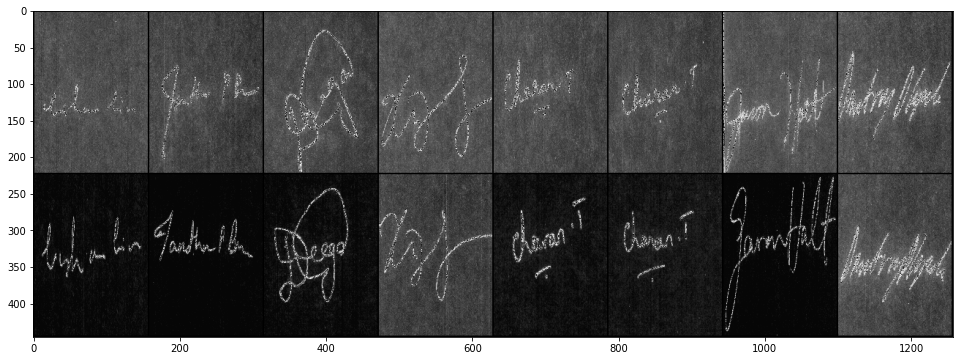

[[0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]]


In [ ]:
train_loader = DataLoader(
    train_signature_dataset,
    shuffle=True,
    num_workers=2,
    batch_size=8
)
dataiter = iter(train_loader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
# # Split datasets
# train_test_split = 0.8  # 80% train, 20% test.
# valid_train_split = 0.2  # 20% valid, 80% train.

# dataset_size = len(signature_dataset)
# indices = list(range(dataset_size))
# np.random.shuffle(indices)  # Random shuffling

# test_split = int(np.floor((1-train_test_split)*dataset_size))
# test_indices, train_indices = indices[:test_split], indices[test_split:]

# train_sampler = SubsetRandomSampler(train_indices)
# test_sampler = SubsetRandomSampler(test_indices)

# train_size = len(train_indices)
# valid_split = int(np.floor(valid_train_split*train_size))
# valid_indices = train_indices[:valid_split]

# valid_sampler = SubsetRandomSampler(valid_indices)

In [ ]:
test_signature_dataset = SignatureVerificationDataset(testx, testy, transforms=transforms_)
test_loader = DataLoader(
    test_signature_dataset,
    shuffle=True,
    num_workers=2,
    batch_size=1,
)

In [ ]:
# batch_size = 8
# num_workers = 2

# train_loader = torch.utils.data.DataLoader(
#     signature_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
# )
# valid_loader = torch.utils.data.DataLoader(
#     signature_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
# )

# # Since we compare each test image separately, batch_size must be one.
# test_loader = torch.utils.data.DataLoader(
#     signature_dataset, batch_size=1, sampler=test_sampler, num_workers=num_workers
# )

# types = ["train", "valid", "test"]
# samplers = {"train": train_sampler, "valid": valid_sampler, "test": test_sampler}
# dataloaders = {x: torch.utils.data.DataLoader(
#                 signature_dataset, batch_size=batch_size, sampler=samplers[x], num_workers=num_workers) for x in types
#               }

In [ ]:
"""
From https://discuss.pytorch.org/t/linear-layer-input-neurons-number-calculation-after-conv2d/28659/2:
> In PyTorch, image data is expected to have the shape [batch_size, channel, height, width].
"""
class SignatureVerificationNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    
    # No. of kernels = No. of out channels (each channel is convolved independently).
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=1)
    self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.fc1 = nn.Linear(108800, 1024)
    self.fc2 = nn.Linear(1024, 128)
    self.lrn = nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
    self.dropout1 = nn.Dropout2d(0.3)
    self.dropout2 = nn.Dropout2d(0.3)

    self.conv_relu_pool_norm = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=1),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout2d(0.3),

        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout2d(0.3),
    )
    self.fc = nn.Sequential(
        nn.Linear(108800, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout2d(0.5),
        nn.Linear(1024, 128),
    )

  def forward_single(self, x):
    x = self.conv_relu_pool_norm(x)
    x = x.view(x.size()[0], -1)
    x = self.fc(x)
    return x

  def forward(self, x1, x2):
    out1 = self.forward_single(x1)
    out2 = self.forward_single(x2)

    return out1, out2

svn = SignatureVerificationNetwork()
svn = svn.to(device)

In [ ]:
class ContrastiveLoss(torch.nn.Module):
  def __init__(self, margin=1.0):  # Margin is set to 1. as per the paper.
    super(ContrastiveLoss, self).__init__()
    self.margin = margin

  def forward(self, output1, output2, label):
    euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
    loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                  (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
    return loss_contrastive

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

criterion = ContrastiveLoss()  # Use above-defined custom loss function.
optimizer = optim.RMSprop(svn.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.0005)

###### TO VERIFY #####
lr_lambda = lambda epoch: 0.1  # TODO: Verify if this follows paper.
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lr_lambda)
######################

scheduler = lr_scheduler.StepLR(optimizer, step_size=8)

epochs = 20  # TODO: Change this to 20.

In [ ]:
# Utility
def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

In [ ]:
counter = []
iteration_number = 0
loss_history = [] 

svn.train()
for epoch in range(epochs):
  for i, data in enumerate(train_loader, 0):
    img0, img1, label = data
    img0, img1, label = img0.to(device), img1.to(device), label.to(device)
    optimizer.zero_grad()
    output1, output2 = svn(img0, img1)
    loss_contrastive = criterion(output1, output2, label)
    loss_contrastive.backward()
    optimizer.step()
    if i % 10 == 0 :
      print("Epoch number {}\n Current loss {}\n".format(epoch, loss_contrastive.item()))
      iteration_number += 10
      counter.append(iteration_number)
      loss_history.append(loss_contrastive.item())

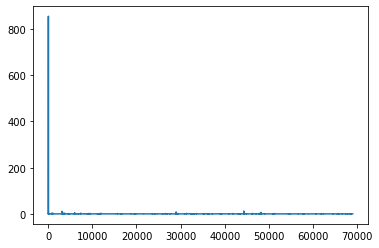

In [ ]:
show_plot(counter, loss_history)

In [ ]:
torch.save(svn.state_dict(), "svn.pth")

In [ ]:
model = SignatureVerificationNetwork().to(device)
model.load_state_dict(torch.load("svn.pth"))

<All keys matched successfully>

In [ ]:
# Util
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose((npimg * 255).astype(np.uint8), (1, 2, 0)))
    plt.show() 

tensor([0.4559], device='cuda:0', grad_fn=<NormBackward1>)


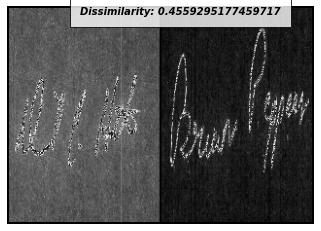

tensor([0.6765], device='cuda:0', grad_fn=<NormBackward1>)


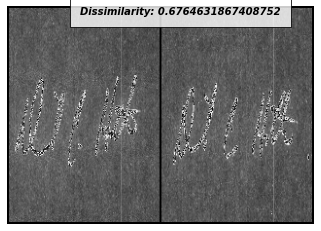

tensor([0.4170], device='cuda:0', grad_fn=<NormBackward1>)


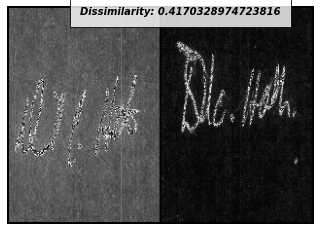

tensor([0.4013], device='cuda:0', grad_fn=<NormBackward1>)


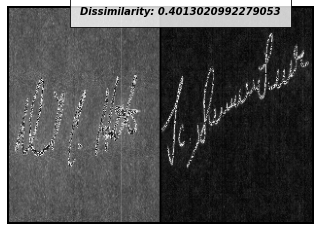

tensor([0.3225], device='cuda:0', grad_fn=<NormBackward1>)


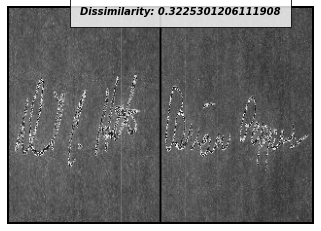

tensor([0.4298], device='cuda:0', grad_fn=<NormBackward1>)


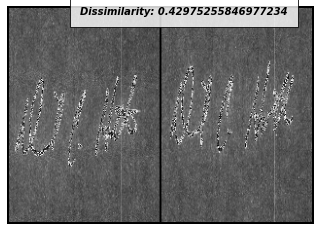

tensor([0.3169], device='cuda:0', grad_fn=<NormBackward1>)


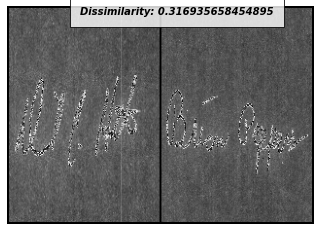

tensor([0.3133], device='cuda:0', grad_fn=<NormBackward1>)


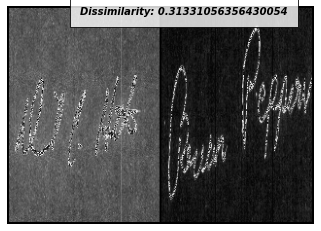

tensor([0.3165], device='cuda:0', grad_fn=<NormBackward1>)


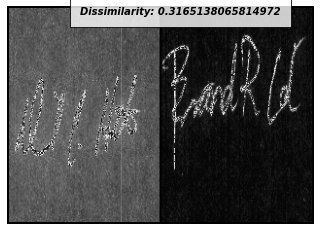

tensor([0.4601], device='cuda:0', grad_fn=<NormBackward1>)


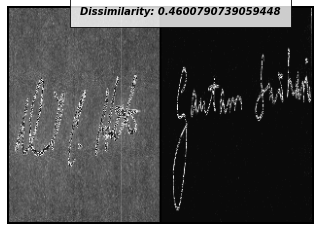

In [ ]:
dataiter = iter(test_loader)
x0, _, _ = next(dataiter)

for i in range(10):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1, output2 = model(x0.to(device), x1.to(device))  # Shape: (1, 128) for both outputs.
    print(F.pairwise_distance(output1, output2))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f"Dissimilarity: {euclidean_distance.item()}")

In [ ]:
accuracy = 0
counter = 0
correct = 0

model.eval()

threshold_distance = 0.5
for i, data in enumerate(test_loader,0): 
    img0, img1, label = data
    output1, output2 = model(img0.to(device),img1.to(device))
    distance = F.pairwise_distance(output1, output2)
    
# #     print(distance)
# #     if distance < threshold_distance:  # Dissimilar
# #         pred_label = 0
# #     else:  # Similar
# #         pred_label = 1
    
# #     if pred_label == label:
# #         correct += 1
    diff = torch.abs(output1.to(device)-output2.to(device))
    label = int(label[0].tolist()[0])
    result = torch.max(diff, 1)[1].data[0].tolist()
    if label == result:
        correct += 1
    counter += 1

accuracy = (correct/len(test_loader))
print(f"Accuracy: {accuracy}")

Accuracy: 0.17898550724637682
